Some examples of how to use `autoregressive` to, in effect, implement a [Kalman filter](https://en.wikipedia.org/wiki/Kalman_filter).

## 1D example

In [83]:
import os
os.environ["SCALAR_BROADCASTING"] = "simple"
import pangolin
from pangolin import interface as pi
from matplotlib import pyplot as plt
import numpy as np

In [109]:
# define 1d random walk with observation noise
start     = 0.0
z_noise   = 1.0
x_noise   = 10.0
timesteps = 250

z = pi.autoregressive(lambda last: pi.normal(last,z_noise), timesteps)(start)
x = pi.vmap(lambda zi: pi.normal(zi, x_noise))(z)

# check that shapes are as expected
assert z.shape == x.shape == (timesteps,)

In [117]:
def plot(z_true, x_obs, z_samps=None):
    plt.plot(x_obs, '.', markersize=2, label='x (data)')
    plt.plot(z_true, label='z (true)');
    
    if z_samps is not None:
        mu = np.mean(z_samps, axis=0)
        lo = np.percentile(z_samps, 2.5, axis=0)
        hi = np.percentile(z_samps, 97.5, axis=0)
        
        plt.plot(mu, 'k-',  alpha=0.75, label='z (posterior mean)',)
        plt.fill_between(np.arange(mu.shape[0]), lo, hi, color='black', edgecolor='none', alpha=0.25, label='z (posterior 95% interval)')

    plt.legend();

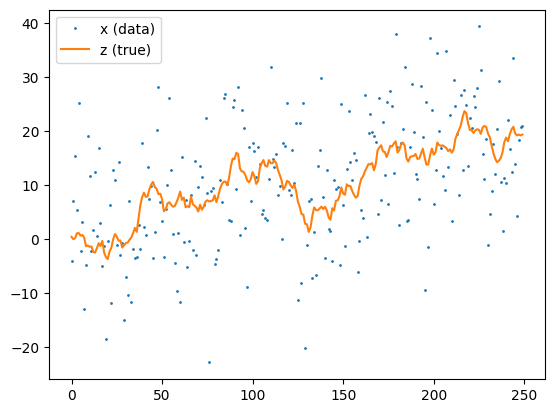

In [114]:
# draw exact sample from model
[z_true, x_obs] = pangolin.backend.ancestor_sample([z, x])

# check that shapes are as expected
assert z_true.shape == x_obs.shape == (timesteps,)

plot(z_true, x_obs)

Now, our question is: How well can we infer `z` from `x`?

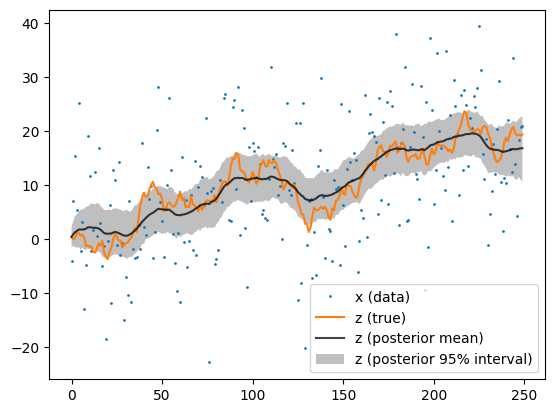

In [ ]:
# do inference: draw samples from posterior p(z | x==x_obs)
niter = 1000 # number of MCMC samples
z_samps = pangolin.blackjax.sample(z, x, x_obs, niter=niter)

# yes, it's that easy.

# check that shape is as expected
assert z_samps.shape == (niter, timesteps)

# show posterior
plot(z_true, x_obs, z_samps)

## 2D example

In [130]:
# define 2d random walk with observation noise
start     = [0.0, 0.0]
z_noise   = 1.0
x_noise   = 10.0
timesteps = 250

z = pi.autoregressive(lambda last: pi.normal(last,z_noise), timesteps)(start)
x = pi.vmap(lambda zi: pi.normal(zi, x_noise))(z)

# check that shapes are as expected
assert z.shape == x.shape == (timesteps, 2)

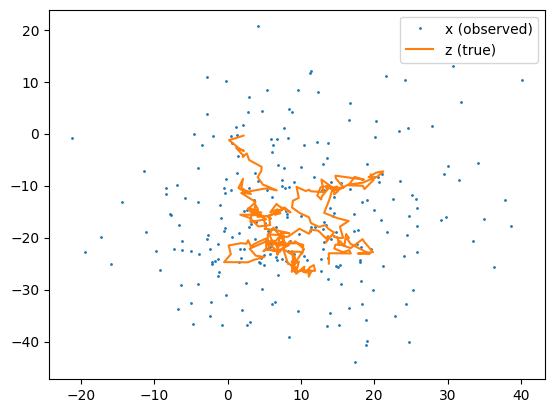

In [131]:
# draw exact sample from model
[z_true, x_obs] = pangolin.backend.ancestor_sample([z, x])

# check that shapes are as expected
assert z_true.shape == x_obs.shape == (timesteps, 2)

# plot
plt.plot(x_obs[:,0], x_obs[:,1], '.', markersize=2, label='x (observed)');
plt.plot(z_true[:,0], z_true[:,1],'-', label='z (true)');
plt.legend();

Now, our question is: How well can we infer `z` from `x`?

In [ ]:
# do inference: draw samples from posterior p(z | x==x_obs)
z_samps = pangolin.blackjax.sample(z, x, x_obs, niter=niter) # yes, it's that easy!

# check that shape is as expected
assert z_samps.shape == (niter, timesteps, 2)

z_mean = np.mean(z_samps, axis=0)
assert z_mean.shape == (timesteps, 2) # or: z_mean = pangolin.blackjax.E(z, x, x_obs)

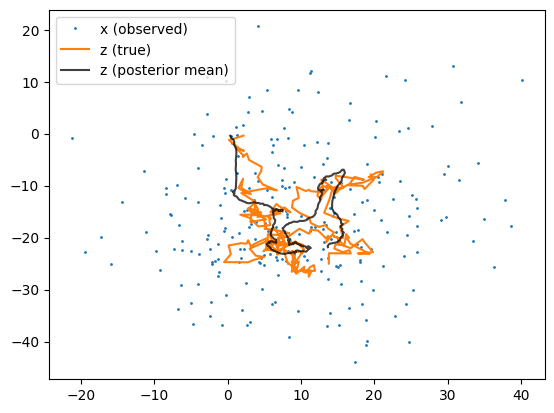

In [133]:
# plot infererred mean in 2d
plt.plot(x_obs[:,0], x_obs[:,1], '.', markersize=2, label='x (observed)');
plt.plot(z_true[:,0], z_true[:,1],'-', label='z (true)');
plt.plot(z_mean[:,0], z_mean[:,1], 'k-', alpha=0.75, label='z (posterior mean)')
plt.legend();

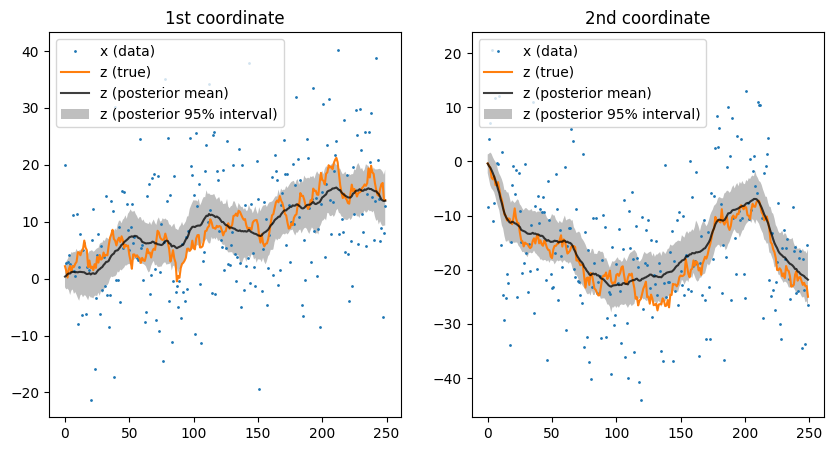

In [134]:
# plot posterior mean and 95% credible interval for each dimension

lo = np.percentile(z_samps, 2.5, axis=0)
hi = np.percentile(z_samps, 97.5, axis=0)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot(z_true[:,0], x_obs[:,0], z_samps[:,:,0])
plt.title('1st coordinate')

plt.subplot(1,2,2)
plot(z_true[:,1], x_obs[:,1], z_samps[:,:,1])
plt.title('2nd coordinate');